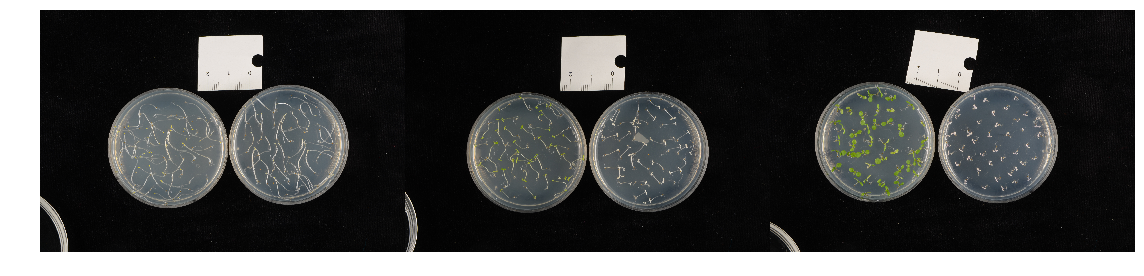

In [1]:
%matplotlib inline
import cv2, sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../..')
from helper import plot_mats

A = cv2.cvtColor(cv2.imread('img/Dark.JPG'), cv2.COLOR_BGR2RGB)
B = cv2.cvtColor(cv2.imread('img/PAR 2.43.JPG'), cv2.COLOR_BGR2RGB)
C = cv2.cvtColor(cv2.imread('img/PAR_58.16.JPG'), cv2.COLOR_BGR2RGB)

plot_mats([A,B,C], cols=3)

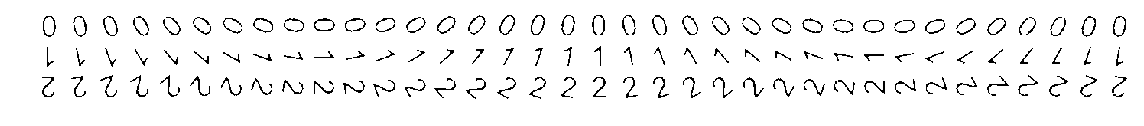

In [2]:
img = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)

h, w = img.shape

resize_factor = 2

img = cv2.resize(img, (int(w * 1/resize_factor), int(h * 1/resize_factor)))

img = cv2.bilateralFilter(img, 10, 1, 1000)
img = cv2.equalizeHist(img)

zero_p = (int(855/resize_factor), int(2801/resize_factor))
one_p = (int(860/resize_factor), int(2514/resize_factor))
two_p = (int(868/resize_factor), int(2235/resize_factor))
w = 100

zero = img[zero_p[0] - w:zero_p[0] + w,
           zero_p[1] - w:zero_p[1] + w].copy()
one = img[one_p[0] - w:one_p[0] + w,
           one_p[1] - w:one_p[1] + w].copy()
two = img[two_p[0] - w:two_p[0] + w,
           two_p[1] - w:two_p[1] + w].copy()

#two = cv2.line(two, (50, 0), (50, 100), (0))
#two = cv2.line(two, (0, 50), (100, 50), (0))

def cut(img):
    #return img
    return (img > 200) * 126

zeros, ones, twos = [], [], []
for a in range(0, 360, 10):
    ax, bx, ay, by = 80, 120, 80, 120
    R = cv2.getRotationMatrix2D((100, 100),a,1)
    dst = cut(cv2.warpAffine(zero,R,(200,200))).astype('uint8')
    zeros.append(dst[ax:bx,ay:by])
    
    dst = cut(cv2.warpAffine(one,R,(200,200))).astype('uint8')
    ones.append(dst[ax:bx,ay:by])
    
    dst = cut(cv2.warpAffine(two,R,(200,200))).astype('uint8')
    twos.append(dst[ax:bx,ay:by])

plot_mats(zeros + ones + twos, cols=36)

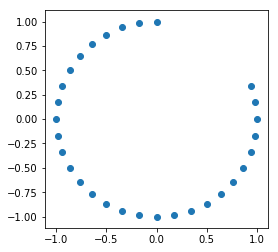

In [8]:
from math import sin, cos, radians

def get_walk_direction(deg):
    a = radians(deg)
    n = np.array([0, 1])
    R = np.array([
        [cos(a), -sin(a)],
        [sin(a), cos(a)]
    ])
    return R @ n

RR = np.array([get_walk_direction(i) for i in range(0, 300, 10)])

X = RR[:,0]
Y = RR[:,1]

fig = plt.figure(figsize=(4, 4))
plt.scatter(X, Y)

rotation: 35
found loc for 0
rotation: 35
found loc for 1
rotation: 35
found loc for 2


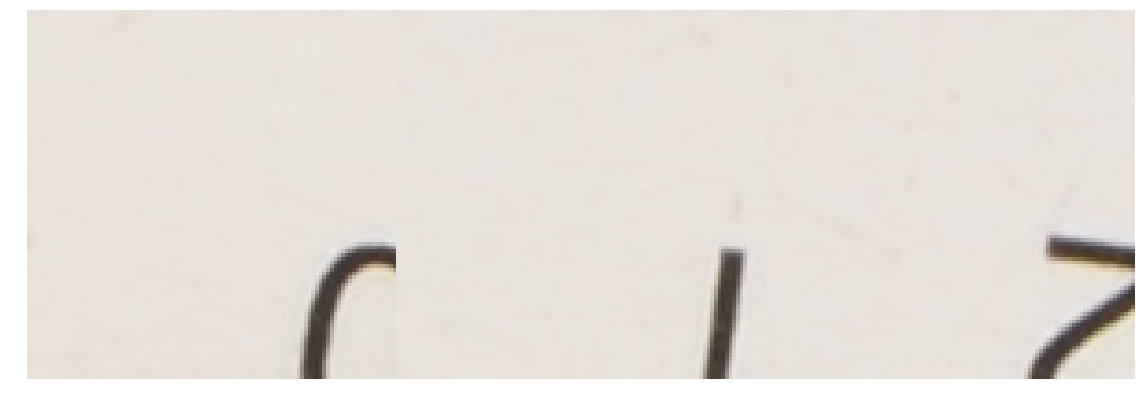

In [4]:
def match_templates(img, templates):
    """ templates are generated with the half-size of the image so
    we can find the locations 
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h, w = img.shape
    img = cv2.resize(img, (int(w * 0.5), int(h * 0.5)))

    img = cv2.bilateralFilter(img, 10, 1, 1000)
    img = cv2.equalizeHist(img)
    
    total_maxLoc = None
    total_maxVal = 0
    total_i = -1
    for i, T in enumerate(templates):
        minv, maxv, minloc, maxloc =cv2.minMaxLoc(
            cv2.matchTemplate(img.astype('uint8'), T, cv2.TM_CCOEFF_NORMED)
        )
        if maxv >= total_maxVal:
            total_maxVal = maxv
            total_maxLoc = maxloc
            total_i = i
            
    return np.array(total_maxLoc) * 2, total_i
    
img = C.copy()

mov = np.array([50, 50])

def get_im(img, T):
    loc, i = match_templates(img, T)
    
    n = get_walk_direction(i)
    #loc = loc + (n * 50)
    #loc = (int(loc[0]), int(loc[1]))
    
    print("rotation: " + str(i))
    return img[loc[1]-50:loc[1]+50, loc[0]-50:loc[0]+50:,], loc

im0, loc0 = get_im(img, zeros)
print('found loc for 0')
im1, loc1 = get_im(img, ones)
print('found loc for 1')
im2, loc2 = get_im(img, twos)
print('found loc for 2')


plot_mats([im0, im1, im2], cols=3)

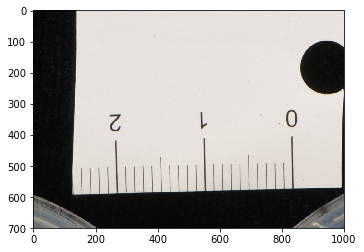

In [15]:
#plt.imshow(A)
plt.imshow(A[500:1200,2000:3000:,])